In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/BERT/

/content/drive/My Drive/Colab Notebooks/BERT


In [ ]:
%ls

0-10000-labeled.csv  huggingface_stats.py  model.png
BERT.ipynb           imdb_bert/            __pycache__/


In [ ]:
pd.read_csv('0-10000-labeled.csv')

,article,highlights,id,label
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,0.0
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,0.0
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,1.0
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,0.0
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,0.0
...,...,...,...,...
9995,"(Oprah.com) -- As a trained chef, restaurant o...",Chef Laura Pensiero: Don't let diet hijack you...,75cd2144a44f902e14b887bf927a08ad6b5fbf54,0.0
9996,"Islamabad, Pakistan (CNN) -- The Pakistani mil...",NEW: Taliban source says commander alive and w...,734ca9a754dd444ed50362375e256fd72d82def5,0.0
9997,(CNN) -- Bastian Schweinsteiger rescued a poin...,Midfielder Bastian Schweinsteiger rescues a po...,8ff4e932c84ed30759427a128879f0af1c8a156a,0.0
9998,"(CNN) -- Haiti's earthquake is creating ""a gen...","Experts say Haiti's earthquake is creating ""a ...",12e6c95b6f47092e953523ae556cb6391a7021f6,0.0


In [ ]:
import huggingface_stats

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil
import re
import string

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from tensorflow.keras import layers

In [ ]:
# news_data = pd.read_csv('0-10000-labeled.csv', dtype = {'label': int})
# news_data.loc[news_data['label'] == 0, 'label_txt'] = 'Not accident'
# news_data.loc[news_data['label'] == 1, 'label_txt'] = 'Accident'
# news_data.head()

In [ ]:
raw_data = pd.read_csv('0-10000-labeled.csv', dtype = {'label': int})
tmp1 = raw_data.loc[raw_data['label'] == 1]
tmp2 = raw_data.loc[raw_data['label'] == 0].sample(n=len(tmp1))
# merge them together to get 50/50 dataset
frames = [tmp1, tmp2]
news_data = pd.concat(frames, ignore_index=True)
news_data.loc[news_data['label'] == 0, 'label_txt'] = 'Not accident'
news_data.loc[news_data['label'] == 1, 'label_txt'] = 'Accident'
news_data.head()

,article,highlights,id,label,label_txt
0,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,1,Accident
1,"WASHINGTON (CNN) -- There is ""no remaining hop...",NEW: President Bush says he and first lady are...,0d43b97000ff852282c89d8d105e41495c0ee9bd,1,Accident
2,"PHUKET, Thailand (CNN) -- Relatives of the 89 ...",Relatives of the 89 people killed in Thai air ...,ee0ba7928d8987f2cb21c9a2012a76730f77de45,1,Accident
3,"SAN DIEGO, California (CNN) -- More than 100 h...",San Diego mayor declares state of emergency; W...,2fff2bc541ef34a6647dfa2e4294cdcc187e47b9,1,Accident
4,"PATUAKHALI, Bangladesh (CNN) -- Survivors of ...",Survivors of Cyclone Sidr in Bangladesh waitin...,ceb7a288ac1ad604a17bc25c5978fcc87b1a4446,1,Accident


In [ ]:
news_features = np.array(news_data['article'])
news_labels = np.array(news_data['label'])

In [ ]:
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

preprocessor = huggingface_stats.Preprocessor(stemmer=EnglishStemmer(),
                                              stopwords=stopwords.words('english'),
                                              re_pattern=re.compile("[a-zA-Z]"))

# pas deze if-statement aan om keyword filteren aan of uit te zetten
filter_by_keywords = False
if filter_by_keywords:
    positive_keywords = ['accident','disaster','catastrophe','incident','near-miss', 'tragedy', 'victim',
                         'casualties','died','killed','damage','harm','hospital','hospitalized',
                         'wounded','succumbed','unscathed','evacuate','rescue','first responders','ambulance',
                         'first aid', 'sunk','fire','derailed','collision','poisoned','burned', 'safety']
    negative_keywords = ['gunman', 'suspect', 'attack', 'terror', 'war', 'bombing', 'militants', 'bombs',
                         'conflict', 'hijacking']
    preprocessor.init_keyword_filter(positive=positive_keywords,
                                     pos_threshold=3,
                                     negative=negative_keywords,
                                     neg_threshold=3)
    pass_filter = preprocessor.batch_keyword_filter(docs=news_features.tolist(), show_progress=True)
    news_features = news_features[np.array(pass_filter)]
    news_labels = news_labels[np.array(pass_filter)]
    print('\n')
    print(np.sum(np.array(pass_filter) == True), 'articles passed')
    print(np.sum(np.array(pass_filter) == False), 'articles did not pass')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
len(news_labels)

978

In [ ]:

from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(news_features, news_labels, test_size=.20)
docs_train, docs_val, y_train, y_val = train_test_split(docs_train, y_train, test_size=.20)


AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100


raw_train_ds = tf.data.Dataset.from_tensor_slices((docs_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((docs_val, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((docs_test, y_test))

raw_train_ds = raw_train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
raw_val_ds = raw_val_ds.batch(BATCH_SIZE)
raw_test_ds = raw_test_ds.batch(BATCH_SIZE)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Article>", text_batch.numpy()[i])
    print("Label>", label_batch.numpy()[i])

Article> b'TAMPA, Florida (CNN) -- Some Florida minimum-security inmates want to know: Can you handle the heat? Inmates work with peppers at the Hillsborough County Jail in Tampa, Florida. Hot sauce heat, that is -- Jail House Fire Hot Sauce, cooked up by inmates at the Hillsborough County Jail and now offered for sale. The idea to make Jail House Fire Hot Sauce came from a Cuban former inmate who thought food in the big house was bland. Allen Boatman, the head of the jail\'s horticulture program, remembers what his former trusty said: "We\'re growing these peppers. Why don\'t we use them?" Peppers are grown as part of the jail\'s horticulture program, which is voluntary and offered only to minimum-security trusties. The inmates learn about growing plants, ornamentals, trees, herbs and vegetables -- including more than 1,200 varieties of peppers. "I thought that was a great idea, so I started doing research on some of the recipes," says Boatman. The research led to a variety of hot sau

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['a construction worker fell into a hole.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1037 2810 7309 3062 2046 1037 4920 1012  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.3087866  -0.9372096   0.05005116 -0.09977908  0.55140865 -0.20155746
  0.24685784 -0.06625542  0.15892512 -0.9913968  -0.7660633  -0.43341866]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19435674  0.6138562   0.29798654 ... -0.29990703  0.04878591
  -0.21768166]
 [ 0.5660328   0.00149103  0.29070723 ... -0.07158913  0.21198297
   0.27493826]
 [-0.0177968  -0.06268548  0.5538385  ... -0.32463932 -0.30568117
   0.36230296]
 ...
 [ 0.06390896  0.29781672  0.10772306 ... -0.4038945  -0.5364255
  -0.52297974]
 [ 0.3582303  -0.01144127  0.38985133 ...  0.21105935  0.10712638
   0.22766595]
 [ 0.38708654 -0.05004887  0.41027212 ...  0.07154264  0.09816952
   0.23685086]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.30526137]], shape=(1, 1), dtype=float32)


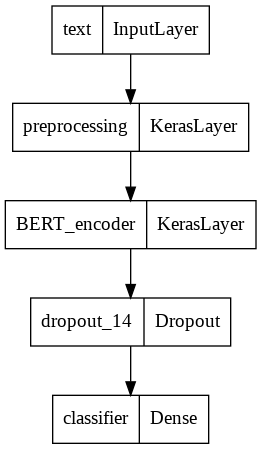

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Epoch 1/5
10/10 [==============================] - 27s 2s/step - loss: 0.6775 - binary_accuracy: 0.6096 - val_loss: 0.4758 - val_binary_accuracy: 0.7898
Epoch 2/5
10/10 [==============================] - 15s 2s/step - loss: 0.4236 - binary_accuracy: 0.8096 - val_loss: 0.3537 - val_binary_accuracy: 0.8535
Epoch 3/5
10/10 [==============================] - 15s 2s/step - loss: 0.3016 - binary_accuracy: 0.8720 - val_loss: 0.3326 - val_binary_accuracy: 0.8599
Epoch 4/5
10/10 [==============================] - 15s 1s/step - loss: 0.2536 - binary_accuracy: 0.8896 - val_loss: 0.3166 - val_binary_accuracy: 0.8726
Epoch 5/5
10/10 [==============================] - 15s 2s/step - loss: 0.2263 - binary_accuracy: 0.9088 - val_loss: 0.3118 - val_binary_accuracy: 0.8854


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 2s 414ms/step - loss: 0.2776 - binary_accuracy: 0.8673
Loss: 0.27755385637283325
Accuracy: 0.8673469424247742


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


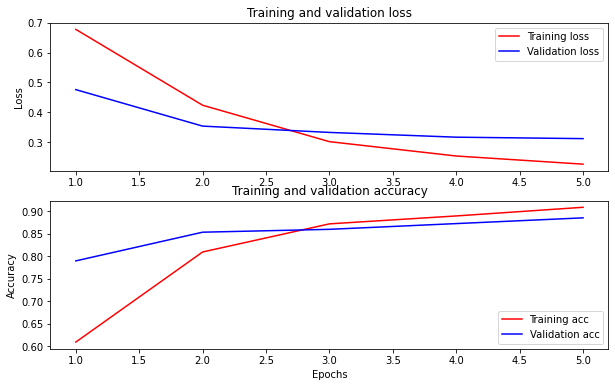

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
test_acc = np.array(docs_test)[np.array(y_test) == 1]
test_not_acc = np.array(docs_test)[np.array(y_test) == 0]

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30}\nscore: {results[i][0]:.6f}\n'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'a man died in a plane crash',
    'a new movie was released',
    'a man was murdered by a murderer',
    'a man fell off scaffolding and hurt his leg',
    'bees are pretty cool i decided'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: a man died in a plane crash   
score: 0.761087

input: a new movie was released      
score: 0.112701

input: a man was murdered by a murderer
score: 0.173487

input: a man fell off scaffolding and hurt his leg
score: 0.804738

input: bees are pretty cool i decided
score: 0.099714


Results from the model in memory:
input: a man died in a plane crash   
score: 0.761087

input: a new movie was released      
score: 0.112701

input: a man was murdered by a murderer
score: 0.173487

input: a man fell off scaffolding and hurt his leg
score: 0.804738

input: bees are pretty cool i decided
score: 0.099714




In [ ]:
examples = test_acc[:10].tolist()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print_my_examples(examples, reloaded_results)

input: (CNN) -- A raging blaze at a fuel storage complex in Puerto Rico lit up the night sky Friday near San Juan as firefighters battled to keep it from spreading further. iReporter Maria Marquez photographed the flames early Friday from the 17th floor of her San Juan condominium. Fifteen of the 40 tanks at the Caribbean Petroleum Corp. facility in the city of Bayamon were ablaze more than 19 hours after an explosion of unknown origin rocked the complex, Gov. Luis Fortuno said at an evening news conference. The governor had put the tally at 11 a few hours earlier. "I don't think there's ever been a fire like this in Puerto Rico," Fire Lt. Jose Atorre told CNN affiliate WLII-TV. The fire started shortly after midnight, when at least one fuel tank exploded. Residents described a surreal scene after the blast woke them from their sleep and shattered windows miles away. "I was in bed and all of a sudden heard this really horrible sound, so I ran upstairs and thought the whole town had blo

In [ ]:
examples = test_not_acc[:10].tolist()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print_my_examples(examples, reloaded_results)

input: Moorhead, Minnesota (CNN) -- He's been there for 30 years, and 85-year-old Lloyd Paulson isn't moving anytime soon. But on his stretch of Rivershore Drive in this city just east of Fargo, North Dakota, he's essentially the only one. "I want to go feet-first out of here," Paulson said from his living room, which is now just feet from rising floodwaters. "I don't want to leave. I want to stay here because I enjoy it so much." Last year, he and his family and friends saved his home from the record flooding that nearly ravaged the entire city -- but it took 30,000 sand bags. A farm boy since birth, Paulson said the sandbagging in 2009 saved his property from major damage, meaning another pleasant year of watching the wildlife in his backyard. "I can see turkeys and squirrels and deer. They come up at night." But when the retired sporting goods store manager looks down the street now, what he sees is a mix of houses on stilts ready to be moved and vacant houses awaiting demolition. T

In [ ]:
test_scores = tf.sigmoid(reloaded_model(tf.constant(docs_test)))

In [ ]:
test_predictions = tf.math.round(test_scores)

In [ ]:
test_predictions = test_predictions.numpy().ravel().astype(int)

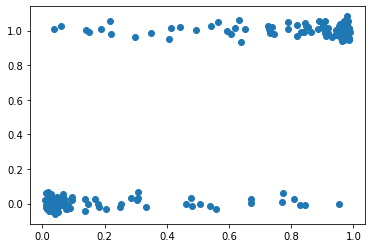

In [ ]:
plt.scatter(test_scores, y_test + np.random.normal(loc=0.0, scale=0.03, size=len(y_test)))

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions, target_names=['not accident', 'accident']))

              precision    recall  f1-score   support

not accident       0.85      0.87      0.86        87
    accident       0.90      0.88      0.89       109

    accuracy                           0.88       196
   macro avg       0.88      0.88      0.88       196
weighted avg       0.88      0.88      0.88       196

